In [119]:
from collections import Counter
import pandas as pd
import rpy2.rinterface
import numpy as np
%load_ext rpy2.ipython

The rpy2.ipython extension is already loaded. To reload it, use:
  %reload_ext rpy2.ipython


## TGCA Survival Analysis of Pancreatic Cancer Patients

### Modified from similar workflow described on biostars.org: https://www.biostars.org/p/153013/

In [120]:
# Download raw counts from Xena, place tsv in data folder
# https://xenabrowser.net/datapages/?dataset=TCGA-PAAD%2FXena_Matrices%2FTCGA-PAAD.htseq_counts.tsv&host=https%3A%2F%2Fgdc.xenahubs.net&removeHub=https%3A%2F%2Fxena.treehouse.gi.ucsc.edu%3A443

In [121]:
HTSeq_raw_df = pd.read_csv("data/TCGA-PAAD.htseq_counts.tsv", sep="\t")

In [122]:
# Visualize the head of the file
HTSeq_raw_df.head()

,Ensembl_ID,TCGA-2J-AAB1-01A,TCGA-2J-AAB4-01A,TCGA-2J-AAB6-01A,TCGA-2J-AAB8-01A,TCGA-2J-AAB9-01A,TCGA-2J-AABA-01A,TCGA-2J-AABE-01A,TCGA-2J-AABF-01A,TCGA-2J-AABH-01A,...,TCGA-XD-AAUH-01A,TCGA-XD-AAUI-01A,TCGA-XD-AAUL-01A,TCGA-XN-A8T3-01A,TCGA-XN-A8T5-01A,TCGA-YB-A89D-01A,TCGA-YB-A89D-11A,TCGA-YH-A8SY-01A,TCGA-YY-A8LH-01A,TCGA-Z5-AAPL-01A
0,ENSG00000000003.13,10.342075,10.997179,10.145932,9.424166,9.980140,10.856426,10.577429,11.116994,10.512740,...,10.290019,10.931476,11.259743,11.397140,10.302639,10.436712,10.644758,10.324181,10.901621,9.390169
1,ENSG00000000005.5,0.000000,0.000000,0.000000,2.584963,0.000000,0.000000,1.000000,2.000000,1.584963,...,3.807355,1.000000,1.000000,2.000000,1.584963,1.584963,8.383704,0.000000,0.000000,6.022368
2,ENSG00000000419.11,9.974415,10.329796,10.976564,9.531381,9.426265,9.930737,9.681238,10.680360,10.299208,...,10.104599,10.529431,10.484823,10.139551,10.225207,10.391244,10.267957,10.307201,10.611025,10.604553
3,ENSG00000000457.12,9.727920,9.751544,8.651052,9.398744,8.451211,9.231221,10.432542,10.520619,10.328675,...,9.497852,9.531381,9.463524,9.672425,9.002815,8.832890,8.731319,8.854868,9.868823,9.579316
4,ENSG00000000460.15,7.734710,7.942515,8.661778,7.672425,6.584963,7.383704,7.247928,9.074141,8.055282,...,7.159871,8.405141,7.900867,8.134426,7.159871,7.499846,7.294621,7.832890,8.044394,8.134426


In [123]:
# These counts are actually partially processed (incremented by one then log transformed)
# We want to undo this so that we are working with the actual raw counts
HTSeq_raw_counts_df = pd.DataFrame()
HTSeq_raw_counts_df['Ensembl_ID'] = HTSeq_raw_df['Ensembl_ID']
for column in HTSeq_raw_df.columns.values[1:]:
    series = HTSeq_raw_df[column]
    series_antilog = (2**series) - 1
    HTSeq_raw_counts_df[column] = series_antilog
       

In [124]:
# Visualize the raw counts
HTSeq_raw_counts_df.head()

,Ensembl_ID,TCGA-2J-AAB1-01A,TCGA-2J-AAB4-01A,TCGA-2J-AAB6-01A,TCGA-2J-AAB8-01A,TCGA-2J-AAB9-01A,TCGA-2J-AABA-01A,TCGA-2J-AABE-01A,TCGA-2J-AABF-01A,TCGA-2J-AABH-01A,...,TCGA-XD-AAUH-01A,TCGA-XD-AAUI-01A,TCGA-XD-AAUL-01A,TCGA-XN-A8T3-01A,TCGA-XN-A8T5-01A,TCGA-YB-A89D-01A,TCGA-YB-A89D-11A,TCGA-YH-A8SY-01A,TCGA-YY-A8LH-01A,TCGA-Z5-AAPL-01A
0,ENSG00000000003.13,1297.0,2043.0,1132.0,686.0,1009.0,1853.0,1527.0,2220.0,1460.0,...,1251.0,1952.0,2451.0,2696.0,1262.0,1385.0,1600.0,1281.0,1912.0,670.0
1,ENSG00000000005.5,0.0,0.0,0.0,5.0,0.0,0.0,1.0,3.0,2.0,...,13.0,1.0,1.0,3.0,2.0,2.0,333.0,0.0,0.0,64.0
2,ENSG00000000419.11,1005.0,1286.0,2014.0,739.0,687.0,975.0,820.0,1640.0,1259.0,...,1100.0,1477.0,1432.0,1127.0,1196.0,1342.0,1232.0,1266.0,1563.0,1556.0
3,ENSG00000000457.12,847.0,861.0,401.0,674.0,349.0,600.0,1381.0,1468.0,1285.0,...,722.0,739.0,705.0,815.0,512.0,455.0,424.0,462.0,934.0,764.0
4,ENSG00000000460.15,212.0,245.0,404.0,203.0,95.0,166.0,151.0,538.0,265.0,...,142.0,338.0,238.0,280.0,142.0,180.0,156.0,227.0,263.0,280.0


In [125]:
# Need to figure out which columns are tumor samples and which columns are normal samples
origin_dict = {}
for column in list(HTSeq_raw_counts_df)[1:]:
    if column[13] == '0':
        origin_dict[column] = 'tumor'
    elif column[13] == '1':
        origin_dict[column] = 'normal'

In [126]:
# Count the number of occurances of each tumor or normal tissue
Counter(origin_dict.values())

Counter({'tumor': 178, 'normal': 4})

In [127]:
# For this analysis I am only interested in tumor samples
# I subset the HTSeq_raw_counts_df to just get tumor samples
slice_list = ['Ensembl_ID']
for column, value in origin_dict.items():
    if value == 'tumor':
        slice_list.append(column)
        
HTSeq_raw_counts_tumors_df = HTSeq_raw_counts_df[slice_list]

In [128]:
# Visualize the HTSeq_raw_counts_tumors_df
HTSeq_raw_counts_tumors_df.head()

,Ensembl_ID,TCGA-2J-AAB1-01A,TCGA-2J-AAB4-01A,TCGA-2J-AAB6-01A,TCGA-2J-AAB8-01A,TCGA-2J-AAB9-01A,TCGA-2J-AABA-01A,TCGA-2J-AABE-01A,TCGA-2J-AABF-01A,TCGA-2J-AABH-01A,...,TCGA-XD-AAUG-01A,TCGA-XD-AAUH-01A,TCGA-XD-AAUI-01A,TCGA-XD-AAUL-01A,TCGA-XN-A8T3-01A,TCGA-XN-A8T5-01A,TCGA-YB-A89D-01A,TCGA-YH-A8SY-01A,TCGA-YY-A8LH-01A,TCGA-Z5-AAPL-01A
0,ENSG00000000003.13,1297.0,2043.0,1132.0,686.0,1009.0,1853.0,1527.0,2220.0,1460.0,...,1126.0,1251.0,1952.0,2451.0,2696.0,1262.0,1385.0,1281.0,1912.0,670.0
1,ENSG00000000005.5,0.0,0.0,0.0,5.0,0.0,0.0,1.0,3.0,2.0,...,33.0,13.0,1.0,1.0,3.0,2.0,2.0,0.0,0.0,64.0
2,ENSG00000000419.11,1005.0,1286.0,2014.0,739.0,687.0,975.0,820.0,1640.0,1259.0,...,835.0,1100.0,1477.0,1432.0,1127.0,1196.0,1342.0,1266.0,1563.0,1556.0
3,ENSG00000000457.12,847.0,861.0,401.0,674.0,349.0,600.0,1381.0,1468.0,1285.0,...,462.0,722.0,739.0,705.0,815.0,512.0,455.0,462.0,934.0,764.0
4,ENSG00000000460.15,212.0,245.0,404.0,203.0,95.0,166.0,151.0,538.0,265.0,...,106.0,142.0,338.0,238.0,280.0,142.0,180.0,227.0,263.0,280.0


In [129]:
# Probably a good idea to remove lowly expressed genes
# Find out where genes have expression of 0 if 50% of samples
zeroes = (HTSeq_raw_counts_tumors_df == 0).astype(int)
zeroes_count = zeroes.sum(axis=1).to_frame()
length = zeroes.shape[1]
zeroes_count = zeroes_count.drop(zeroes_count[zeroes_count[0] < length/2].index)
drop_index_list = zeroes_count.index.to_list()

In [130]:
# Drop rows where genes have expression of 0 if 50% of samples
HTSeq_raw_counts_tumors_no_zeroes_df = HTSeq_raw_counts_tumors_df.drop(labels=drop_index_list)

In [131]:
# Determine how many rows were dropped due to low gene expression
before_drop = HTSeq_raw_counts_tumors_df.shape[0]
after_drop = HTSeq_raw_counts_tumors_no_zeroes_df.shape[0]
number_dropped = before_drop - after_drop
number_dropped

29034

In [132]:
# Need to convert floats counts to integer, otherwise DESeq2 will complain
for column in HTSeq_raw_counts_tumors_no_zeroes_df.columns.values[1:]:
    HTSeq_raw_counts_tumors_no_zeroes_df[column] = HTSeq_raw_counts_tumors_no_zeroes_df[column].astype(int)
    

In [133]:
# Visualize results of float -> int conversion
HTSeq_raw_counts_tumors_no_zeroes_df.head()

,Ensembl_ID,TCGA-2J-AAB1-01A,TCGA-2J-AAB4-01A,TCGA-2J-AAB6-01A,TCGA-2J-AAB8-01A,TCGA-2J-AAB9-01A,TCGA-2J-AABA-01A,TCGA-2J-AABE-01A,TCGA-2J-AABF-01A,TCGA-2J-AABH-01A,...,TCGA-XD-AAUG-01A,TCGA-XD-AAUH-01A,TCGA-XD-AAUI-01A,TCGA-XD-AAUL-01A,TCGA-XN-A8T3-01A,TCGA-XN-A8T5-01A,TCGA-YB-A89D-01A,TCGA-YH-A8SY-01A,TCGA-YY-A8LH-01A,TCGA-Z5-AAPL-01A
0,ENSG00000000003.13,1297,2042,1131,686,1009,1852,1526,2219,1459,...,1126,1250,1952,2451,2695,1262,1384,1280,1911,669
1,ENSG00000000005.5,0,0,0,4,0,0,1,3,1,...,32,13,1,1,3,1,1,0,0,64
2,ENSG00000000419.11,1005,1285,2013,739,686,974,820,1639,1259,...,834,1100,1476,1432,1127,1195,1341,1265,1562,1556
3,ENSG00000000457.12,846,861,401,674,348,599,1381,1468,1284,...,461,721,739,704,814,512,454,461,933,763
4,ENSG00000000460.15,212,245,403,202,94,165,150,537,264,...,105,142,338,237,279,142,179,226,263,279


In [134]:
# Iteratively save a tsv corresponing to the raw counts for each tumor
# needed to pass data off to DESeq2
for column in HTSeq_raw_counts_tumors_no_zeroes_df.columns.values[1:]:
    file_name = 'data/tumor_samples/' + column + '.tsv'
    HTSeq_raw_counts_tumors_no_zeroes_df[['Ensembl_ID', column]].to_csv(file_name, sep=" ", header=False, index=False)

In [135]:
%%R
# load the R libraries
library("DESeq2")

In [136]:
%%R
# Asssign the directory of the rna samples
rna_data_directory <- 'data/tumor_samples'

# Build the sampleTable based on the data files we have
sampleFiles <- list.files(rna_data_directory)
sampleNames <- gsub(".tsv", "", sampleFiles)
sampleCondition <- c(rep("tumor", 178))
sampleTable <- data.frame(sampleName = sampleNames,
                          fileName = sampleFiles,
                          condition = sampleCondition)

In [137]:
%%R

# Make a DESeq dataset using the sample table and directory to the datafiles
# The design is set to 1 to indicate that there are no factors dividing these groups
# i.e. they are all tumor samples, see: https://support.bioconductor.org/p/64122/
dds <- DESeqDataSetFromHTSeqCount(sampleTable = sampleTable,
                                       directory = rna_data_directory,
                                       design= ~ 1)

In [138]:
%%R

# http://people.duke.edu/~ccc14/duke-hts-2017/Statistics/08032017/DESeq2-Notebook-introduction.html
# Tranform raw counts to rlog
# Transformation takes several hours, will load R object with results already if already exists 

if (!file.exists("transformed_dds.rds")) {
    
        transformed_dds <- rlog(dds, blind=TRUE)
        saveRDS(transformed_dds, file = "transformed_dds.rds")
    
    } else {
    
        transformed_dds <- readRDS(file = "transformed_dds.rds")
}

In [139]:
%%R

# Get the summarized experiement object, which is a matrix of the transformed counts
# Save this matrix to the temp folder

transformed_dds_matrix <- assay(transformed_dds)
write.csv(transformed_dds_matrix, "temp/transfored_dds_matrix.csv")


In [140]:
# Load the transforemed_dds_matrix with pandas

transformed_dds_matrix = pd.read_csv("temp/transfored_dds_matrix.csv")
transformed_dds_matrix = transformed_dds_matrix.rename(index=str, columns={"Unnamed: 0": "Ensembl_ID"})

In [141]:
# Calculate the 75th percentile of each row

# Need to slice only the columns for samples
sample_columns = transformed_dds_matrix.columns.values[1:]
#transformed_dds_matrix['75th_percentile'] = transformed_dds_matrix[sample_columns].apply(lambda x: np.percentile(x, 75), axis=1)

In [142]:
# calculate the median for each row 

transformed_dds_matrix['median'] = transformed_dds_matrix[sample_columns].apply(lambda x: np.median(x), axis=1)

In [143]:
# Download "merge_clinical" clinical data from firebrowse http://gdac.broadinstitute.org/runs/stddata__2016_01_28/data/PAAD/20160128/gdac.broadinstitute.org_PAAD.Merge_Clinical.Level_1.2016012800.0.0.tar.gz
# Extract and place the "PAAD.merged_only_clinical_clin_format.txt" file in the "data/clinical" folder
# Read the Clinical file, in this case I transposed it to keep the clinical feature title as column name
clinical_dir = 'data/clinical/PAAD.merged_only_clinical_clin_format.txt'
clinical_df = pd.read_csv(clinical_dir, sep='\t', index_col='V1').T


In [144]:
# Visualize the head of the file
clinical_df.head()

V1,admin.batch_number,admin.bcr,admin.day_of_dcc_upload,admin.disease_code,admin.file_uuid,admin.month_of_dcc_upload,admin.patient_withdrawal.withdrawn,admin.project_code,admin.year_of_dcc_upload,patient.additional_studies,...,patient.tissue_prospective_collection_indicator,patient.tissue_retrospective_collection_indicator,patient.tissue_source_site,patient.tobacco_smoking_history,patient.tumor_tissue_site,patient.tumor_type,patient.vital_status,patient.year_of_form_completion,patient.year_of_initial_pathologic_diagnosis,patient.year_of_tobacco_smoking_onset
V2,424.43.0,nationwide children's hospital,21,paad,cda0d295-ea13-4065-9e5d-8177e827a8f6,1,false,tcga,2016,NaN,...,no,yes,2j,3,pancreas,primary,dead,2014,2012,1962
V3,424.43.0,nationwide children's hospital,21,paad,d25a44b7-47b1-4a1b-ae08-7bd9aceab9c8,1,false,tcga,2016,NaN,...,no,yes,2j,5,pancreas,primary,alive,2014,2012,NaN
V4,424.43.0,nationwide children's hospital,21,paad,6f72d859-d6af-4a35-8836-2e086684d90f,1,false,tcga,2016,NaN,...,no,yes,2j,NaN,pancreas,primary,dead,2014,2012,NaN
V5,424.43.0,nationwide children's hospital,21,paad,ca534fd7-dad2-4bd8-9017-391bb314c4a8,1,false,tcga,2016,NaN,...,no,yes,2j,NaN,pancreas,primary,alive,2014,2012,NaN
V6,424.43.0,nationwide children's hospital,21,paad,650295d6-db83-4fa3-909e-4640a77e6274,1,false,tcga,2016,NaN,...,no,yes,2j,1,pancreas,primary,dead,2014,2012,NaN


In [145]:
# Convert patient barcodes to uppercase
clinical_df['patient.bcr_patient_barcode'] = clinical_df['patient.bcr_patient_barcode'].str.upper()

In [146]:
# Similarly get the earliest recording of days to death
# This should be unambiguous, but we take the max anyway just to pick one value if there are multiple entries

death_df = pd.DataFrame()
death_df['patient.bcr_patient_barcode']  = clinical_df['patient.bcr_patient_barcode']
for column in clinical_df:
    if 'days_to_death' in column:
        death_df[column] = clinical_df[column]
        death_df[column] = death_df[column].astype(float)
        death_df['death_days'] = death_df.max(axis=1)

death_df = death_df[['patient.bcr_patient_barcode', 'death_days']]

In [147]:
# Similarly get the most recent number for "days to last followup"
# Days_to_last_followup is the time interval from the date of last followup to the date of initial pathologic diagnosis
# This means the most recent followup would be the largest number

followup_df = pd.DataFrame()
followup_df['patient.bcr_patient_barcode']  = clinical_df['patient.bcr_patient_barcode']
for column in clinical_df:
    if 'days_to_last_followup' in column:
        followup_df[column] = clinical_df[column]
        followup_df[column] = followup_df[column].astype(float)
        followup_df['followup_days'] = followup_df.max(axis=1)

followup_df = followup_df[['patient.bcr_patient_barcode', 'followup_days']]

In [148]:
# Merge new_tumor_df, death_df, followup_df
df_list = [death_df, followup_df]
all_clinical_df = pd.DataFrame()
all_clinical_df['patient.bcr_patient_barcode'] = clinical_df['patient.bcr_patient_barcode']
for df in df_list:
    all_clinical_df = all_clinical_df.merge(df, on='patient.bcr_patient_barcode')

In [149]:
# Need to create a column for death that takes into account samples that need to be censored (patients that did not die)
# If the patient did die, the time to death will be recorded in this column
# If the patient did not die, the number of days since last followup will be recorded in this column

all_clinical_df['new_death']= np.where(all_clinical_df['death_days'].isnull(),all_clinical_df['followup_days'] , all_clinical_df['death_days'])

In [150]:
# Translate the alive and dead strings in the patient.vital_status column to 1 for dead and 0 for alive

alive_dead_df = clinical_df[['patient.bcr_patient_barcode', 'patient.vital_status']]
alive_dead_df['death_event'] = np.where(alive_dead_df['patient.vital_status'] == 'dead', 1, 0)
alive_dead_df = alive_dead_df[['patient.bcr_patient_barcode', 'death_event']]

/home/brett/.local/lib/python3.6/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  after removing the cwd from sys.path.


In [151]:
# Merge the alive/dead data with the all_clincal_df data

all_clinical_df = all_clinical_df.merge(alive_dead_df, on='patient.bcr_patient_barcode')

In [152]:
# Function can be used to find a gene from an ensembl root
def find_gene_id(id):
    for item in transformed_dds_matrix['Ensembl_ID']:
        if id in item:
            return item
            
# The root ensembl id for MET is ENSG00000105976
print(find_gene_id('ENSG00000105976'))

# The root ensembl id for RON is ENSG00000105976
print(find_gene_id('ENSG00000164078'))

ENSG00000105976.13
ENSG00000164078.11


In [153]:
# Select rows from transformed_dds_matrix with our two genes of interest
met = find_gene_id('ENSG00000105976')
ron = find_gene_id('ENSG00000164078')
met_expression = transformed_dds_matrix[transformed_dds_matrix['Ensembl_ID'] == met]
ron_expression = transformed_dds_matrix[transformed_dds_matrix['Ensembl_ID'] == ron]

In [154]:
# The subsets of transformed_dds_matrix that contain the rows corresponding of the genes of interest need to be transposed

def transpose_df_subset(subset, gene_name):
    
    # Transpose the subset of data
    subset_transposed = subset.T.reset_index()
    
    # Prepare the header for merging with the clinical data 
    new_header = ['patient.bcr_patient_barcode', '{}_normalized_counts'.format(gene_name)]
    subset_transposed = subset_transposed[1:]
    subset_transposed.columns = new_header

    # Truncate barcodes for merging with the clinical data
    subset_transposed['patient.bcr_patient_barcode'].iloc[:-1] = subset_transposed['patient.bcr_patient_barcode'].str[:-4]
    
    return subset_transposed

# Apply the function to the two genes of interest

met_expression_transposed = transpose_df_subset(met_expression, 'met')

ron_expression_transposed = transpose_df_subset(ron_expression, 'ron')

In [155]:
# Get the median transformed count value from the dataframe for each gene

met_expression_median = met_expression_transposed.iloc[-1, 1]
ron_expression_median = ron_expression_transposed.iloc[-1, 1]

# Drop the median row from each of the dataframes

met_expression_transposed = met_expression_transposed.iloc[:-1]
ron_expression_transposed = ron_expression_transposed.iloc[:-1]

In [156]:
# Merge the transformed count data from the genes of interest with the clinical data

all_clinical_df = all_clinical_df.merge(met_expression_transposed, on='patient.bcr_patient_barcode')
all_clinical_df = all_clinical_df.merge(ron_expression_transposed, on='patient.bcr_patient_barcode')

# Convert type of normalized counts series from string to float
all_clinical_df['met_normalized_counts'] = all_clinical_df['met_normalized_counts'].astype(float)
all_clinical_df['ron_normalized_counts'] = all_clinical_df['ron_normalized_counts'].astype(float)


In [157]:
# Generate a new series for the event_rna levels
all_clinical_df['event_rna'] = pd.Series()

In [158]:
# Code high Met and Ron expressing samples as those expressing both Met and Ron above the median level
all_clinical_df['event_rna'] = np.where(((all_clinical_df['met_normalized_counts'] > met_expression_median) & (all_clinical_df['ron_normalized_counts'] > ron_expression_median)), 
                                        'high_met_high_ron', all_clinical_df['event_rna'])

In [159]:
# Code low Met and high Ron expressing samples as those expressing Ron above the median level and Met below the median level
all_clinical_df['event_rna'] = np.where(((all_clinical_df['met_normalized_counts'] < met_expression_median) & (all_clinical_df['ron_normalized_counts'] > ron_expression_median)), 
                                        'low_met_high_ron', all_clinical_df['event_rna'])

In [160]:
# Code high Met and low Ron expressing samples as those expressing Met above the median level and Ron below the median level
all_clinical_df['event_rna'] = np.where(((all_clinical_df['met_normalized_counts'] > met_expression_median) & (all_clinical_df['ron_normalized_counts'] < ron_expression_median)), 
                                        'high_met_low_ron', all_clinical_df['event_rna'])

In [161]:
# Code low Met and low Ron expressing samples as those expressing Ron and Met below the median level
all_clinical_df['event_rna'] = np.where(((all_clinical_df['met_normalized_counts'] < met_expression_median) & (all_clinical_df['ron_normalized_counts'] < ron_expression_median)), 
                                        'low_met_low_ron', all_clinical_df['event_rna'])

In [163]:
# Save the all_clincal_df to the temp folder

all_clinical_df.to_csv("temp/all_clinical_df.csv", index=False)


In [164]:
%%R

# Load the survival library and survminer for plotting
library(survival)
library(survminer)

In [165]:
%%R

# Read in the all_clinical_df from the temp folder
all_clinical_df <- read.csv(file="temp/all_clinical_df.csv", header=TRUE, sep=",")

# Relevel the factors to have low_met_low_ron as the reference factor
all_clinical_df$event_rna <- factor(all_clinical_df$event_rna, levels = c('low_met_low_ron',
                                                                         'high_met_low_ron',
                                                                         'low_met_high_ron',
                                                                         'high_met_high_ron'))

# Create the survival object with the time to death/last followup and death event data 
survival_object <- Surv(time=all_clinical_df$new_death, event=all_clinical_df$death_event)

# Fit the Kaplan-Meier curve with the survfit function

fit <- survfit(formula = survival_object ~ event_rna, data = all_clinical_df)

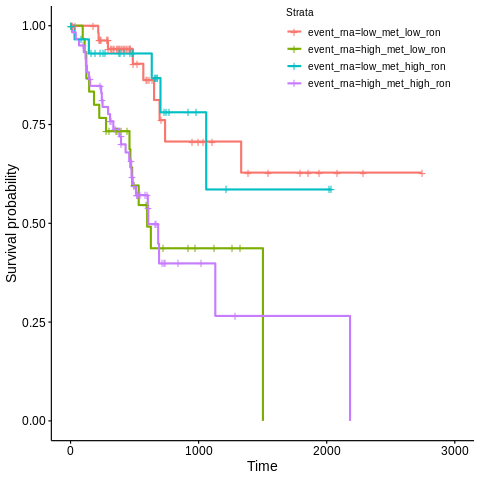

In [166]:
%%R

# Plot the Kaplan-Meier curve

ggsurvplot(fit, data = all_clinical_df, pval = FALSE, legend = c(.75,.9))

In [167]:
%%R

# Perform moderated pair-wise comparisons of all surival curves

pairwise_survdiff(Surv(new_death, death_event) ~ event_rna, data=all_clinical_df)


	Pairwise comparisons using Log-Rank test 

data:  all_clinical_df and event_rna 

                  low_met_low_ron high_met_low_ron low_met_high_ron
high_met_low_ron  0.00308         -                -               
low_met_high_ron  0.98212         0.01546          -               
high_met_high_ron 0.00084         0.98212          0.01088         

P value adjustment method: BH 
